# Calibration Procedure

* Compute center offset:
 - Set $\lambda_{\rm center}$ to set of known spectral lines
 - Measure pixel position of each: 
 - average each to determine central pixel $n_o$
 
|   $\lambda_{\rm center}$ | Pixel |           
| ----------------------:  |:------:|
| 0   nm                   | 5.2 | 
| 445 nm                   | 6.22      |  
| 901 nm                   | 3.1      | 


 
* Compute spectrometer calibration angles/length ($\ f_L, \delta, \gamma$)
 * Move known spectral line $\lambda_o$ to left and right sides of detector
 * record $\lambda_{\rm center}$ and pixel position for each 
 * Compute best fit of $\ f_{\rm calib}$


| $\lambda_o$   | Side | $\lambda_{\rm center}$| Pixel  |
| ------------- | ---- |:----------------------|-------:|
| 809.4 nm      | R    |729.4910 nm            |508     |
| 809.4 nm      | L    |899.5830 nm            |  4     |
| ...           | ...  | ...                   |...     |



# Optimization Function

Optimize for 3 parameters:
 * $f_L$: Focal length of spectrometer
 * $\delta$: Detector angle (The angle of the image plane relative to the plane perpendicular to the spectrograph focal axis at the center of the image plane)
 * $\gamma$: inclusion angle

from experiment:
 * $n =  n_{px} - n_o$: Pixel from central pixel
 * $\lambda_{\rm center}$: Wavelength of center pixel 
 * $\lambda_p$: Wavelength of pixel $n$
 
Fixed Constants:
 * $m$: Diffraction order (typically one)
 * $x_{\rm pixel}$: pixel size
 * $d_{grating}$: Grating pitch (1/(groves / mm))
    
residual: (wl,  wl_p, n, f, delta,gamma)

We measure pixel position ($n$) of a known wavelength ($\lambda_p$) for multple peaks and spectrometer positions and find the best fit parameters $\ f_L, \delta, \gamma$:

$$ \lambda_p = f_{\rm calib} ( n,  \lambda_{\rm center}, 
    \underbrace{m, x_{\rm pixel}, d_{\rm grating}}_{\rm spec\ params}, 
    \overbrace{f_L,\ \ \delta,\ \ \gamma}^{\rm Calibration\ params} ) $$

$$ \lambda_p = \frac{d}{m} \cdot \left[ \sin( \psi - \frac{\gamma}{2}) + \sin(\psi+\frac{\gamma}{2} + \eta) \right]$$

Where

$$ \psi = \arcsin \left[ \frac{ m\ \lambda_{\rm center} } { 2\ d_{\rm grating} \cos(\frac{\gamma}{2})} \right] $$

$$ \eta = \arctan \left[ \frac{ n\ x_{pixel} \cos{\delta}} {f_L + n\ x_{pixel} \sin(\delta)} \right]$$

$$n =  n_{px} - n_o$$



In [4]:
from __future__ import division
import numpy as np
import  matplotlib.pyplot as plt
from pprint import pprint
import numpy as np

%matplotlib notebook

In [5]:
def wl_p_calib_p2(px, n0, wl_center, m_order, d_grating, x_pixel, f, delta, gamma,curvature):
    #consts
    #d_grating = 1./150. #mm
    #x_pixel   = 16e-3 # mm
    #m_order   = 1 # diffraction order, unitless
    n = px - n0

    psi = np.arcsin( m_order* wl_center / (2*d_grating*np.cos(gamma/2.)))
    eta = np.arctan(n*x_pixel*np.cos(delta) / (f+n*x_pixel*np.sin(delta)))
    
    return ((d_grating/m_order)
                    *(np.sin(psi-0.5*gamma)
                      + np.sin(psi+0.5*gamma+eta))) + curvature*n**2

In [11]:
from scipy.optimize import least_squares

def fit_residual(
                # optimization parameters
                opt_params, 
                # other params and data
                px, n0, wl_center, m_order, d_grating, x_pixel,
                wl_actual
                ):
    
    (f, delta, gamma, curvature) = opt_params
    wl_model = wl_p_calib_p2(px, n0, wl_center, m_order, d_grating, x_pixel, f, delta, gamma, curvature)
    return wl_model - wl_actual

# grating 3 (150 g/mm Bz 500)

<IPython.core.display.Javascript object>


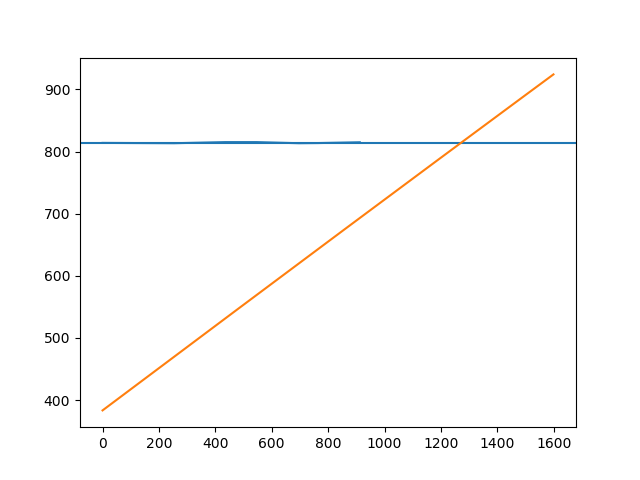

In [12]:
# grating 3 (150 g/mm Bz 500)

wl_center_data = np.array([
[0,     814],
[253.652, 813.5],
[435.833, 815.25],
[546.074, 815.25],
[696.543, 813.5],
[763.511, 813.75],
[912.297, 815.0],    
])
    
n0 = np.mean(wl_center_data[:,1])
n0    
plt.figure(1)
plt.plot(wl_center_data[:,0], wl_center_data[:,1])
plt.axhline(n0)

In [13]:
dispersion_data = np.array([
#wl_actual, wl_center, pixel
[253.652, 503, 84],
[435.833, 685, 79],
[546.074, 796, 75],
[696.543, 946, 75.5],
[763.511, 1013, 73],
[912.297, 1162, 68],
[253.652, 3, 1546],
[435.833, 185, 1549],
[546.074, 296, 1548],
[696.543, 446, 1554.5],
[763.511, 513, 1556],
[912.297, 662, 1556],
[  0.000,   0,  814],
[253.652, 253.652, 813.5],
[435.833, 435.833, 815.25],
[546.074, 546.074, 815.25],
[696.543, 696.543, 813.5],
[763.511, 763.511, 813.75],
[912.297, 912.297, 815.0],    
])


In [14]:
initial_guess = (300,1,0,0)

kwargs = dict(
    px=dispersion_data[:,2], 
    n0=np.mean(wl_center_data[:,1]),
    wl_center=dispersion_data[:,1]*1e-6,
    m_order=1,
    d_grating=1/150.,
    x_pixel=16e-3,
    wl_actual=dispersion_data[:,0]*1e-6
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs)
result.x

array([  2.94140472e+02,   1.53027802e-01,   5.66787871e-01,
         4.14598404e-12])

In [16]:
kwargs = dict(
    px=dispersion_data[:,2], 
    #px=wl_center_data[:,1],
    n0=np.mean(wl_center_data[:,1]),
    wl_center=dispersion_data[:,1]*1e-6,
    #wl_center=wl_center_data[:,0]*1e-6,
    m_order=1,
    d_grating=1/150.,
    x_pixel=16e-3,
    #wl_actual=dispersion_data[:,0]*1e-6,
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    curvature = result.x[3]
)

wl_p_calib_p2(**kwargs)*1e6 - dispersion_data[:,0]
#wl_p_calib(**kwargs)*1e6 - wl_center_data[:,0]

array([ 0.3567654 , -0.38257917, -0.25384708,  0.46464951,  0.11918278,
       -0.28170513,  0.19104198, -0.1015802 , -0.39871603,  0.32654932,
        0.40237017, -0.43595999, -0.11060528, -0.28097204,  0.31617111,
        0.31526408, -0.27776102, -0.19286648,  0.22805891])

In [25]:
kwargs = dict(
    px=np.arange(1600), 
    #px=wl_center_data[:,1],
    n0=np.mean(wl_center_data[:,1]),
    wl_center=660e-6,
    #wl_center=wl_center_data[:,0]*1e-6,
    m_order=1,
    d_grating=1/150.,
    x_pixel=16e-3,
    #wl_actual=dispersion_data[:,0]*1e-6,
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    curvature = result.x[3]
)

wl_p_calib_p2(**kwargs)*1e6


array([ 383.38707513,  383.72767142,  384.0682662 , ...,  923.61069001,
        923.94558327,  924.28047108])

<IPython.core.display.Javascript object>


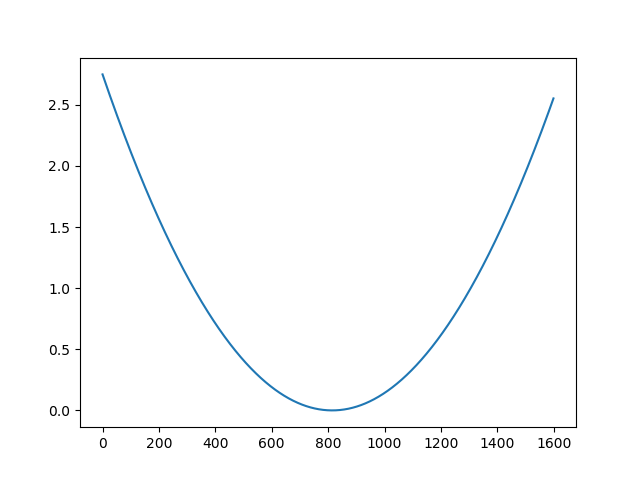

In [26]:
plt.figure()
a = wl_p_calib_p2(**kwargs)*1e6
kwargs = dict(
    px=np.arange(1600), 
    #px=wl_center_data[:,1],
    n0=np.mean(wl_center_data[:,1]),
    wl_center=660e-6,
    #wl_center=wl_center_data[:,0]*1e-6,
    m_order=1,
    d_grating=1/150.,
    x_pixel=16e-3,
    #wl_actual=dispersion_data[:,0]*1e-6,
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    curvature = 0
)
b = wl_p_calib_p2(**kwargs)*1e6
plt.plot(a-b)

In [28]:
result.x

array([  2.94140472e+02,   1.53027802e-01,   5.66787871e-01,
         4.14598404e-12])

In [ ]:
# grating 1 (300 g/mm Bz 500)

wl_center_data = np.array([
[0,     825],
[253.652, 825.5],
[435.833, 826.5],
[546.074, 825.5],
[696.543, 826.75],
[763.511, 825.5],
[912.297, 827.0],    
])
    
n0 = np.mean(wl_center_data[:,1])
n0    
plt.figure(2)
plt.plot(wl_center_data[:,0], wl_center_data[:,1])
plt.axhline(n0)

In [ ]:
print(wl_center_data[:,0] - 120)
print(wl_center_data[:,0] + 130)

In [ ]:
dispersion_data = np.array([
#wl_actual, wl_center, pixel
[253.652, 384, 55],
[435.833, 566, 49.5],
[546.074, 676, 47.5],
[696.543, 826, 41],
[763.511, 894, 34.5],
[912.297, 1042, 28.5],
[253.652, 134, 1526],
[435.833, 316, 1535],
[546.074, 426, 1542],
[696.543, 577, 1544.5],
[763.511, 644, 1547.5],
[912.297, 792, 1558.5],
[0, 0,    825],
[253.652, 253.652, 825.5],
[435.833, 435.833, 826.5],
[546.074, 546.074, 825.5],
[696.543, 696.543, 826.75],
[763.511, 763.511, 825.5],
[912.297, 912.297, 827.0],     
])

In [ ]:
initial_guess = (300,1,0.1)

kwargs = dict(
    px=dispersion_data[:,2], 
    n0=np.mean(wl_center_data[:,1]),
    wl_center=dispersion_data[:,1]*1e-6,
    m_order=1,
    d_grating=1/300.,
    x_pixel=16e-3,
    wl_actual=dispersion_data[:,0]*1e-6
)

result = least_squares(fit_residual, initial_guess, kwargs=kwargs)
result.x

In [ ]:
kwargs = dict(
    px=dispersion_data[:,2], 
    #px=wl_center_data[:,1],
    n0=np.mean(wl_center_data[:,1]),
    wl_center=dispersion_data[:,1]*1e-6,
    #wl_center=wl_center_data[:,0]*1e-6,
    m_order=1,
    d_grating=1/300.,
    x_pixel=16e-3,
    #wl_actual=dispersion_data[:,0]*1e-6,
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
)

wl_p_calib(**kwargs)*1e6 - dispersion_data[:,0]
#wl_p_calib(**kwargs)*1e6 - wl_center_data[:,0]

In [ ]:
plt.figure()
a = wl_p_calib_p2(**kwargs)*1e6
kwargs = dict(
    px=np.arange(1600), 
    #px=wl_center_data[:,1],
    n0=np.mean(wl_center_data[:,1]),
    wl_center=660e-6,
    #wl_center=wl_center_data[:,0]*1e-6,
    m_order=1,
    d_grating=1/300.,
    x_pixel=16e-3,
    #wl_actual=dispersion_data[:,0]*1e-6,
    f = result.x[0],
    delta = result.x[1],
    gamma = result.x[2],
    curvature = 0
)
b = wl_p_calib_p2(**kwargs)*1e6
plt.plot(a-b)